# Loading the Datasets and Initial Commentary


In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
# from wordcloud import WordCloud, STOPWORDS
from re import sub

There are a total of 7 datasets, one of which is a geojson file for the neighborhoods in New York. We will exclude it from the initial EDA since that dataset contains the geographical location of the neighborhoods, which is less interesting than the neighborhoods that the listings are in (we can get this data from the listings dataset). Therefore, we will load the remaining 6 datasets.

In [2]:
listings = pd.read_csv('../Data/listings.csv') 
reviews = pd.read_csv('../Data/reviews.csv')
reviews_full = pd.read_csv('../Data/reviews_full.csv')
listings_full = pd.read_csv('../Data/listings_full.csv')
# neighborhood = pd.read_csv('../Data/neighbourhoods.csv')
calendar = pd.read_csv('../Data/calendar.csv')

/Users/gary/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Exploring the relationship between location, price, and number of listings

Intuitively, the nightly rate of a listing is likely to be correlated with the location of the listing. Also, the number of listings in a neighborhood may be associated with the neighborhood location, too. Furthermore, we imagine the nightly price may be related to the number of listings in the region due to the supply-demand dynamics. Therefore, we will visualize the relationship between location, price, and number of listings in the scatter plot below.

In [8]:
# prepare sub-group data for the plot of price against neighborhood location
data_neighbor_all = (
    listings
    .groupby("neighbourhood")
)

count_by_neighbor = data_neighbor_all["id"].count()
price_by_neighbor = data_neighbor_all["price"].agg(np.mean)
latitude_by_neighbor = data_neighbor_all["latitude"].agg(np.mean)
longitude_by_neighbor = data_neighbor_all["longitude"].agg(np.mean)

metric_by_neighbor = pd.DataFrame({
        "count" : count_by_neighbor,
        "price" : price_by_neighbor,
        "latitude": latitude_by_neighbor,
        "longitude": longitude_by_neighbor
    }
)

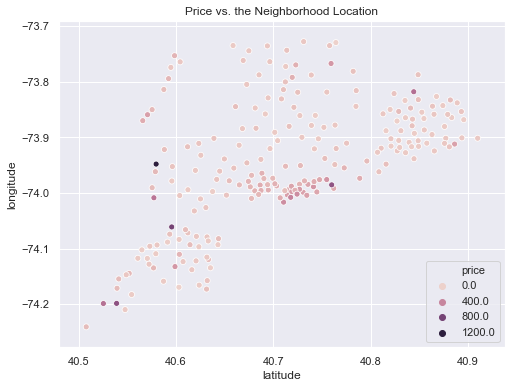

In [14]:
sns.set(color_codes=True)
fig = plt.figure(figsize=(8,6))
plot1 = sns.scatterplot(data = metric_by_neighbor, x = "latitude", y = "longitude"
                        ,hue = "price" 
#                         ,size = "count"
#                         ,sizes = (50, 500)
                       )
plot1.set_title("Price vs. the Neighborhood Location")
plot1.legend(loc = "lower right")
fig.savefig('img/neighbor_price.png')

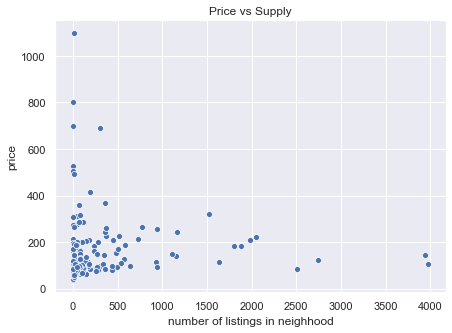

In [54]:
fig = plt.figure(figsize=(7,5))
sns.scatterplot(data = metric_by_neighbor,  x = "count", y = "price")
plt.xlabel('number of listings in neighhood')
plt.title('Price vs Supply')
fig.savefig('img/price_supply.png')

Let's now check the exact neighborhoods that have the most expensive listings or the highest number of listings.

In [7]:
print(metric_by_neighbor["price"].sort_values(ascending = False).head(), end = '\n\n')
print(metric_by_neighbor["count"].sort_values(ascending = False).head())

neighbourhood
Manhattan Beach     1098.800000
Fort Wadsworth       800.000000
Woodrow              700.000000
Theater District     690.763754
Country Club         525.000000
Name: price, dtype: float64

neighbourhood
Bedford-Stuyvesant    3974
Williamsburg          3936
Harlem                2746
Bushwick              2504
Hell's Kitchen        2052
Name: count, dtype: int64


Surprisingly, listings in Manhattan Beach (in Brooklyn) have the highest average listing price, whereas Bedford-Stuyvesant provides the largest number of listings. 

### Distributions of number of bedrooms, bathrooms, guests to be accommodated, and the number beds

The number of bedrooms, bathrooms, guests to be accommodated, and the number of beds are also potential features of a listing that can impact the price. Hence, we want to have a first glance of these four variables. 

In [4]:
def to_num(x):
    x = re.sub(r',', '', x)
    return float(x[1:])

listings_full['price'] = list(map(to_num, listings_full['price']))

139.05030068899597
111.035838737669
10.0
105.0
999.0


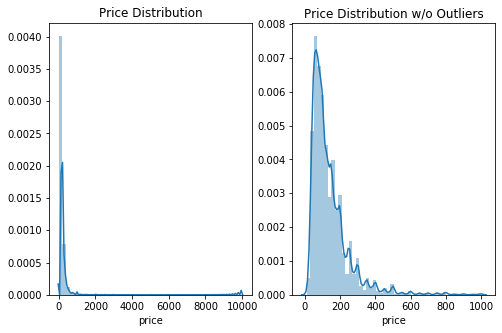

In [12]:
fig = plt.figure(figsize=(8,5))
plt.subplot(121)
sns.distplot(listings_full["price"])
plt.title('Price Distribution')
plt.subplot(122)
price_excl_outlier = listings_full["price"][(listings_full["price"] < 1000) & (listings_full["price"] > 0)]
sns.distplot(price_excl_outlier)
plt.title('Price Distribution w/o Outliers')
print(np.mean(price_excl_outlier))
print(np.std(price_excl_outlier))
print(np.min(price_excl_outlier))
print(np.median(price_excl_outlier))
print(np.max(price_excl_outlier))
fig.savefig('img/price_dist.png')

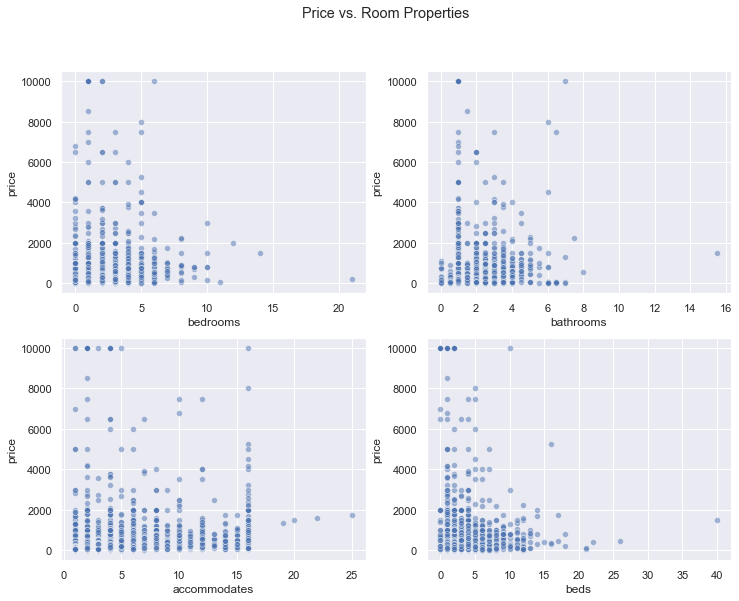

In [29]:
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
# sns.distplot(listings_full["bedrooms"].dropna(), kde=False)
sns.scatterplot(listings_full["bedrooms"], listings_full["price"], alpha = 0.5, y_jitter = True)
plt.subplot(222)
# sns.distplot(listings_full["bathrooms"].dropna(), kde=False)
sns.scatterplot(listings_full["bathrooms"], listings_full["price"], alpha = 0.5, y_jitter = True)
plt.subplot(223)
# sns.distplot(listings_full["accommodates"].dropna(), kde=False)
sns.scatterplot(listings_full["accommodates"], listings_full["price"], alpha = 0.5, y_jitter = True)
plt.subplot(224)
# sns.distplot(listings_full["beds"].dropna(), kde=False)
sns.scatterplot(listings_full["beds"], listings_full["price"], alpha = 0.5, y_jitter = True)
fig.suptitle('Price vs. Room Properties')
fig.savefig('img/room_price.png')

Looking at the distributions, it appears that in general, most values of these quantities are below 5 while outliers exist in each of these variables. As such, we might consider excluding the outliers when creating our models.

### Price vs. Number of Reviews 

We think the number of reviews for a listing should also impact its price, so let's explore that relationship now.

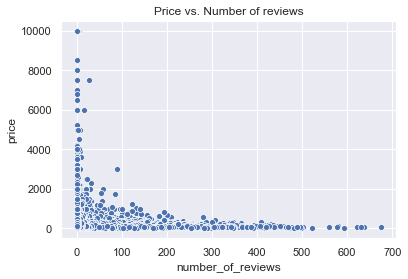

In [6]:
fig = plt.figure()
sns.scatterplot(x = listings["number_of_reviews"], y = listings["price"])
plt.title('Price vs. Number of reviews')
fig.savefig('img/review_num_price.png')

In [5]:
sns.set(color_codes=True)

(50599, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


In the scatterplot, we can see that as the number of reviews increases, the price actually decreases, which was contrary to our initial expectation. One possible reason for this is that when the price of a listing is extremely high, fewer people are willing to rent that listing, and conversely, cheaper listings will be more popular and thus have more reviews.

### Price vs. Reviews per Month

One concern with the previous plot is that older listings may have more reviews, but the age of listing likely doesn't have any impact on the price. Therefore, we also want to look at the relationship between price and reviews per month. Ideally, we should observe the same relationship as price and number of reviews.

Text(0.5, 1.0, 'Price vs. Reviews per month')

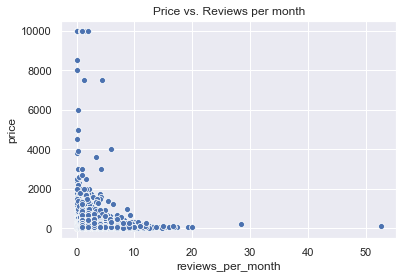

In [38]:
sns.scatterplot(x = listings["reviews_per_month"], y = listings["price"])
plt.title('Price vs. Reviews per month')

As it turns out, we observe a similar pattern to the previous scatter plot (price vs. number of reviews), where the price decreases as the number of reviews per month increase, which is what we expected (and hoped) we would observe.

### Listing Types

One interesting feature in the listings dataset is the type of listing. The listing can fall into four different categories: entire home/apartment, private room, shared room, and hotel room. Let's look at the distribution of listing types.

In [14]:
price = listings["price"]
print(sum(price > 2000))
price = price[price <= 2000]
room_type = listings["room_type"]
room_type.value_counts()

113


Entire home/apt    26141
Private room       22785
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64

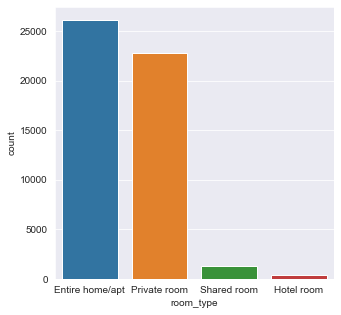

In [15]:
fig = plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.countplot(listings['room_type'])
fig.savefig('img/room_type_dist.png')

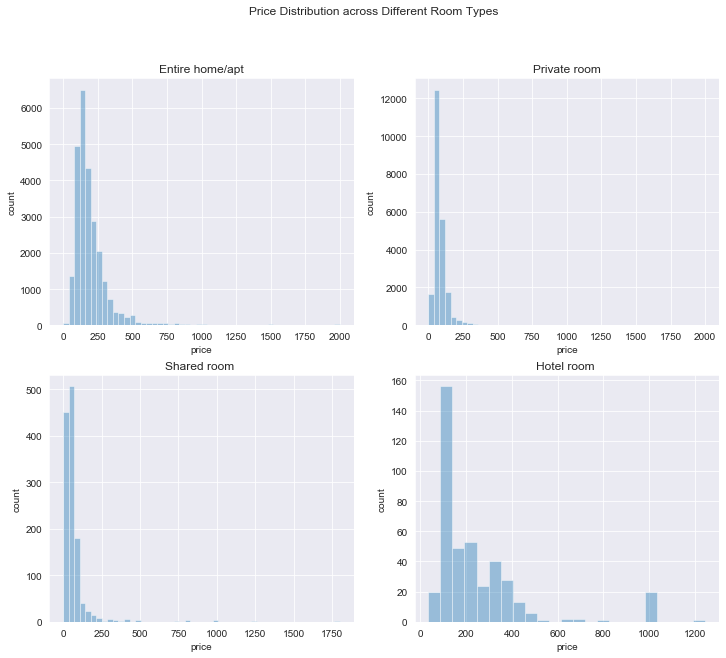

In [17]:
fig = plt.figure(figsize=(12,10))
plt.subplot(221)
plt1 = sns.distplot(price[room_type == "Entire home/apt"],kde=False)
plt1.set_title("Entire home/apt")
plt1.set_ylabel("count")
plt.subplot(222)
plt1 = sns.distplot(price[room_type == "Private room"], kde=False)
plt1.set_title("Private room")
plt1.set_ylabel("count")
plt.subplot(223)
plt1 = sns.distplot(price[room_type == "Shared room"], kde=False)
plt1.set_title("Shared room ")
plt1.set_ylabel("count")
plt.subplot(224)
plt1 = sns.distplot(price[room_type == "Hotel room"], kde=False)
plt1.set_title("Hotel room ")
plt1.set_ylabel("count")
fig.suptitle('Price Distribution across Different Room Types')
fig.savefig('img/room_type_price.png')

In the plot, we can see that the "Entire home/apt" and "Private room" listing types are the most popular by far while the "Shared room" and "Hotel room" listings are much lower in frequency. From this, we can infer that our dataset is dominated by listings that are entire homes/apartments or private rooms in a home/apartment.

# Calendar

In [107]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19812,2019-12-05,f,105.0,$105.00,3.0,90.0
1,2595,2019-12-06,f,175.0,$175.00,10.0,1125.0
2,2595,2019-12-07,f,175.0,$175.00,10.0,1125.0
3,2595,2019-12-08,f,175.0,$175.00,10.0,1125.0
4,2595,2019-12-09,f,175.0,$175.00,10.0,1125.0


In [106]:
calendar.dropna(inplace = True)
calendar['price'] = list(map(to_num, calendar['price']))

In [113]:
def unique_listing(x):
    return len(np.unique(x))
calendar_summary = (
    calendar
    [['listing_id', 'date', 'price']]
    .groupby('date')
    .agg(
#         listing_count = ('listing_id', unique_listing),
        mean_price = ('price', np.mean)
    )
)

In [124]:
calendar_summary = calendar_summary.sort_values('date')

In [1]:
fig = plt.figure()
plt.plot(range(len(calendar_summary)), calendar_summary['mean_price'])
plt.xlabel('day of the year')
plt.ylabel('average price of all listings')
plt.title('Price vs. Day of the Year')
fig.savefig('calendar.png')

NameError: name 'plt' is not defined

# Reviews

The full reviews dataset contains 6 features: listing_id, review id, date, reviewer_id, reviewer_name, and comments. We will create new features based on the comments and do EDA on those features. Here are the features we made:

1. nwords: the number of words on the review
2. punc_prop: the proportion of punctuations used in a comment
3. excl: whether or not there are more than 2 exclamation points in a row in a comment
4. propC: the proportion of capitalized letters in a comment.

We believe these features will give us insights into the nature of the reviews and could reflect certain qualities that may be helpful to our model later. 

Furthermore, one of our goals in this project is to create a sentiment score for each review, and use those scores as a predictor for listing income. Since our data is unlabeled by nature, we need to use an unsupervised learning algorithm to first categorize the data into (roughly) three groups of positive, negative and neutral sentiments. To accomplish that, we created a word cloud, which we will use later in our sentiment score assignments. 

In [12]:
## drop observations in the datset with no reviews
reviews_full = reviews_full.dropna(subset=["comments"])
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


### Feature 1: Number of Words

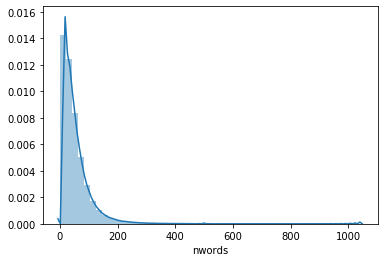

In [13]:
## count the length of a review in terms of number of words
def count_words(string):
    return len(string.split())

reviews_full["nwords"] = reviews_full["comments"].apply(count_words)
sns.distplot(reviews_full["nwords"])

Not surprisingly, the distribution of comments is highly right skewed, and most comments seem to be fewer than 200 words long.

### Feature 2: Proportion of punctuations

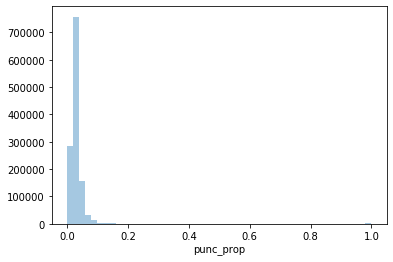

In [14]:
## returns the proportion of punctuation marks in the comment
def prop_punc(input_str):
    return len(re.findall(f"[{string.punctuation}]", input_str))/len(input_str)

reviews_full["punc_prop"] = reviews_full["comments"].apply(prop_punc)
sns.distplot(reviews_full["punc_prop"], kde=False)

In [7]:
reviews_full["comments"][reviews_full["punc_prop"]>.6]

301         .
2361        .
3752       :)
5960       ..
14351       .
           ..
1249935     .
1250789     .
1253146     .
1253249     .
1255242     .
Name: comments, Length: 1435, dtype: object

It appears that there are quite a few "reviews" that contain only punctuation marks. We can interpret this as some kind of empty review (since I'm assuming the users put these "reviews" in because Airbnb required them to comment on the accomodation in some way). The fact that these users left these "empty" reviews may say something about the accomodation or the host, so we will keep this in mind as we build our model.

The nightly rate of a listing is highly likely to correlated with the location of the listing. The number of listings in a neighborhood may be associated with the neighborhood location, too. Furthermore, we imagine the nightly price may be related to the number of listings in the region due to the supply-demand dynamics. Therefore, we will visualize the relationship between location, price, and number of listings in the scatter plot below.

### Feature 3: More than 2 exclamation points in a row 

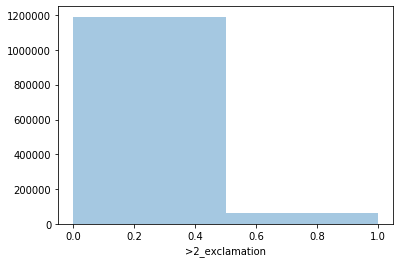

In [15]:
## returns 1 if there is more than 2 exclamation marks in a row in the review
def excl(input_str):
    return int(len(re.findall("!!(.*)", input_str))>0)

reviews_full[">2_exclamation"] = reviews_full["comments"].apply(excl)
sns.distplot(reviews_full[">2_exclamation"], kde=False, bins=2)

In [16]:
print(sum(reviews_full[">2_exclamation"] == 1)) # number of reviews with more than 2 exclamation marks
print(sum(reviews_full[">2_exclamation"] == 1)/len(reviews_full)) # proportion of reviews

64276
0.05123006023971549


As expected, most reviews don't include more than 2 exclamation marks in a row, but of the over 1.2 million reviews, 64,276 comments do, which makes it a nontrivial proportion ($\approx 5\%$) of the total reviews. 

### Feature 4: Proportion of capitalized letters


[(0, 0.3)]

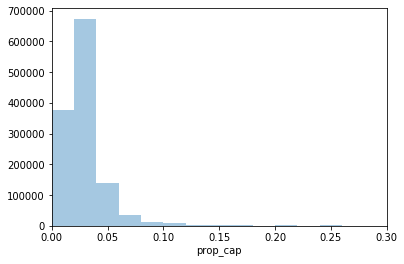

In [17]:
upper = re.compile('[A-Z]')

def prop_cap(input_str):
    return len(upper.findall(input_str))/len(input_str)

reviews_full["prop_cap"] = reviews_full["comments"].apply(prop_cap)

hist = sns.distplot(reviews_full["prop_cap"], kde=False)
hist.set(xlim=(0, .3))

It appears that most reviews don't have over 10% capitalized letters. However, those reviews that do have over 10% capitalized letters might say something about the accomodation or the host, so we will keep this feature in mind when we build our model.

In [18]:
review_summary = (
    reviews_full
    [['listing_id', 'nwords', 'punc_prop', '>2_exclamation', 'prop_cap']]
    .groupby("listing_id")
    .agg({
        'nwords': np.mean, 
        'punc_prop': np.mean,
        '>2_exclamation': np.mean, 
        'prop_cap': np.mean
    })
)

In [19]:
review_summary.reset_index().head()
listing_price = listings[['id', 'price']]
price_review = pd.merge(listing_price, review_summary, 'left', left_on = 'id', right_on = 'listing_id')

In [20]:
price_review.dropna(inplace = True)
price_review = price_review[price_review['price'] > 0]

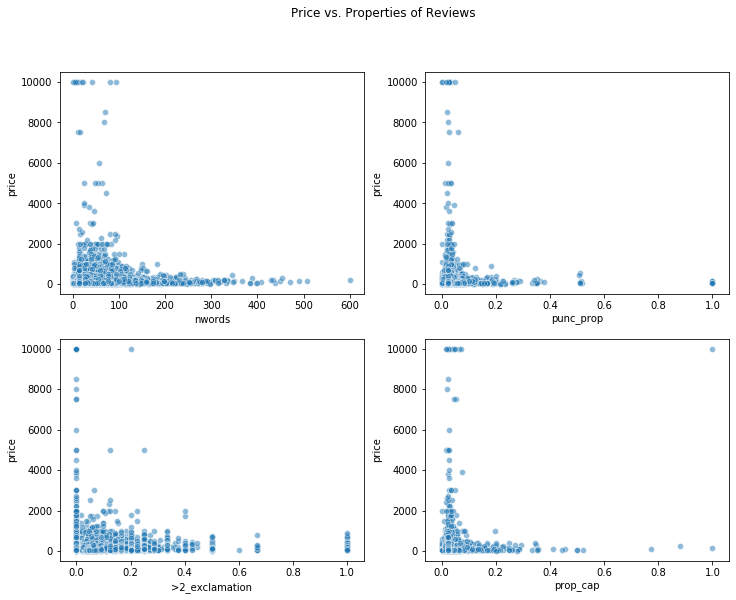

In [22]:
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
sns.scatterplot('nwords', 'price', data = price_review, alpha = 0.5, y_jitter = True)
plt.subplot(222)
sns.scatterplot('punc_prop', 'price', data = price_review, alpha = 0.5, y_jitter = True)
plt.subplot(223)
sns.scatterplot('>2_exclamation', 'price', data = price_review, alpha = 0.5, y_jitter = True)
plt.subplot(224)
sns.scatterplot('prop_cap', 'price', data = price_review, alpha = 0.5, y_jitter = True)
fig.suptitle('Price vs. Properties of Reviews')
fig.savefig('img/review_price.png')

## Word Cloud

Again, in order to assign a sentiment score to the reviews, we need to know what positive/negative words are there in a sentence, so we will create a word cloud to understand what kinds of words exist in our data.

In [11]:
comments = reviews_full.comments.dropna()
comments.head()

0    Notre séjour de trois nuits.\r\nNous avons app...
1                                    Great experience.
2    I've stayed with my friend at the Midtown Cast...
3    We've been staying here for about 9 nights, en...
4    We had a wonderful stay at Jennifer's charming...
Name: comments, dtype: object

We see there are not only English comments in the dataset (which is normal considering the size of New York). For the purpose of analysis, we now drop the comments that are non-English:

In [12]:
## return true if string is detected as English
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [13]:
def clean(s):
    s = sub(r"[,!?.\/)('‘’“”+-:;–—\r\n\t\xa0]", " ", s)
    return (s)

comments = comments.apply(clean) # Perform data cleaning to avoid false positives for English

In [14]:
comments.loc[comments.apply(isEnglish)==False] # Non-English comments to be dropped

0          Notre séjour de trois nuits   Nous avons appré...
21         Tiene una ubicación excelente  Buen equipamien...
33         Jennifer es un anfitrión increíble  Siempre es...
53         Lisa était sympa  toujours prête à aider  L ét...
58         Bien que la chambre soit défraichi  nous avons...
                                 ...                        
1255194    Un lugar muy tranquilo  La anfitriona fue muy ...
1255214    Excelente lugar  Sin dudas nos quedaríamos ahí...
1255222    Lovely touch when we arrive  ❤️  Amazing place...
1255231                 Хорошо  но райончик стремноватенький
1255244    Buen lugar todo ordenado y  privado además par...
Name: comments, Length: 137219, dtype: object

Some reviews that contain emoji's that are hard to detect using regular expressions. We decide to drop them nonetheless, as our false discovery rate should be low anyways.

In [15]:
eng_comments = comments.loc[comments.apply(isEnglish)] # just the English comments
text = eng_comments.str.cat(sep = ' ').lower()

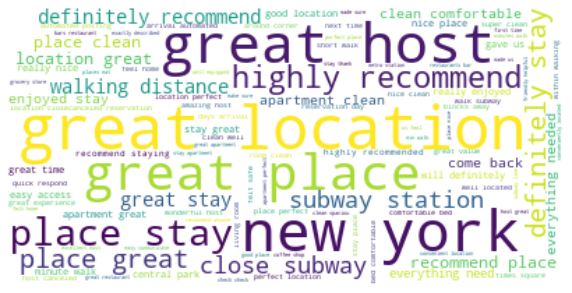

In [16]:
## Generate the word cloud

wc = WordCloud(background_color="white", repeat=False, stopwords=set(STOPWORDS))
wc.generate(text)

fig = plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
fig.savefig('wordcloud.png', dpi = fig.dpi)
plt.show()

Finally, we managed to pull a word cloud, which gives us an intuition of the distribution of words.

- Positive: There is a majority of good words such as 'great host', 'great location', 'recommend', 'clean';

- Neutral: There are neutral words featuring objective things such as 'New York', 'subway station', 'central park';

- Negative: The frequency of bad words is low. Though, we found posts like below which supposingly conveys negative emotions: